In [423]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import os
from sklearn.metrics import mean_squared_error

In [424]:
channels = ['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7'
            , 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz'
            , 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2', 'ACC_X', 'ACC_Y', 'ACC_Z']
removed_channels = ['Fp1', 'F8', 'F7', 'Fp2', 'F3', 'F4']
# TODO ADD AUX WHEN CONNECTED
eye_data_names = ['x', 'y', 'z', 'left_blink', 'right_blink', 'both_blink', 'left_openness', 'right_openness']
freq = ['8.18', '9', '10', '11.25', '12.86', '15']
columns =  channels

data, header = pyxdf.load_xdf('data/ERPSpellerDataV1/ERPSpellerDataD30Sec11-25hz/dejittered-eeg.xdf')
data_iir, header2 = pyxdf.load_xdf('data/ERPSpellerDataV1/ERPSpellerDataD30Sec11-25hz/dejittered-iir-eeg.xdf')
data_frequencies, header3 =  pyxdf.load_xdf('data/ERPSpellerDataV1/ERPSpellerDataD30Sec11-25hz/dejittered-unity-frequencies.xdf')

In [425]:
def get_time_stamps(stamps: list):
    start = []
    end = []
    more_than_one = False

    for i in range(len(stamps)):
        if i == (len(stamps)-1):
            if(stamps[i-1] == (stamps[i] - 1)):
                end.append(stamps[i])
            break

        if(stamps[i] == (stamps[i+1] - 1)):
            if not more_than_one:
                start.append(stamps[i])
            more_than_one = True
            continue
        else:
            if more_than_one:
                end.append(stamps[i])
                more_than_one = False

    return start, end

In [426]:
def plot_eeg_blink_single_norm(df,df_ts, start, end,column,rang = 50, scale=1, flip = False):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    axis.plot(df_ts['time'][start-rang:end+rang], (df_norm + plus) *(-1 if flip else 1) *scale, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Amplitude ")
    axis.set_title(column)
    plt.legend()
    plt.show()

def plot_eeg_blink_single(df,df_ts, start, end,column,rang = 50):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")

    axis.plot(df_ts['time'][start-rang:end+rang], df[column], label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], df['left_openness'], color='orange', label = "Eye openness left - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], df['right_openness'], color='violet', label = "Eye openness right - SRanipal")
    axis.set_title(column)
    plt.legend()
    plt.show()

In [427]:

def init_data(data, shift = 0):
    for s in data:
        stream = s
        y = stream['time_series']
        df_stream = pd.DataFrame(y)
        df_stream_ts = pd.DataFrame(stream['time_stamps'])
        df_stream_ts.columns = ['time']
        df_stream.columns = columns
        return stream, df_stream, df_stream_ts

def init_freq_data(data):
        for s in data:
            stream = s
            y = stream['time_series']
            df_stream = pd.DataFrame(y)
            df_stream_ts = pd.DataFrame(stream['time_stamps'])
            df_stream_ts.columns = ['time']
            df_stream.columns = freq
            return stream, df_stream, df_stream_ts


In [428]:
from scipy.signal import butter, lfilter
# Sample rate and desired cutoff frequencies (in Hz).

def plot_eeg_single(df,df_ts, column, scale=1, start = 0, end = 0):
    df[column] = df[column][start:end]
    df_norm = (df[column].abs() / df[column].abs().max())
    df_norm = df[column]
    y = (df_norm) *scale
    peaks, _ = signal.find_peaks(y)
    axis = plt.subplot()
    for i in peaks:
        plt.plot(df_ts['time'][i], y[i], marker="o", markersize=5, markeredgecolor="turquoise", markerfacecolor="black", label="Local maximum " + str(y[i].round(2)) + ", " + str(i))
    axis.plot(df_ts['time'], y)
    axis.set_title(column)
    plt.show()


def plot_freq_single(df,df_ts, column, scale=1, start = 0, end = 0):
    df[column] = df[column][start:end]
    df_norm = (df[column].abs() / df[column].abs().max())
    y = df[column]
    peaks, _ = signal.find_peaks(y)
    axis = plt.subplot()
    for i in peaks:
        plt.plot(df_ts['time'][i], y[i], marker="o", markersize=5, markeredgecolor="turquoise", markerfacecolor="black", label="Local maximum " + str(y[i].round(2)) + ", " + str(i))
    axis.plot(df_ts['time'], y)
    axis.set_title(column)
    plt.show()

def plot_eeg_freq(df,df_ts, column, df_freq, df_ts_freq, column_freq, scale=1, start = 0, end = 0):
    df[column] = df[column][start[0]:end[0]]
    df_freq[column_freq] = df_freq[column_freq][start[1]:end[1]]
    df_norm = (df[column].abs() / df[column].abs().max())
    df_norm = df[column]
    y = (df_norm) *scale
    peaks, _ = signal.find_peaks(y)
    axis = plt.subplot()
    for i in peaks:
        plt.plot(df_ts['time'][i], y[i], marker="o", markersize=5, markeredgecolor="turquoise", markerfacecolor="black", label="Local maximum " + str(y[i].round(2)) + ", " + str(i))

    axis.plot(df_ts_freq['time'], df_freq[column_freq]*40)
    axis.plot(df_ts['time'], y)
    axis.set_title(column)
    plt.show()

In [429]:


def find_shift(start, peaks):
    differences_start = []
    differences_end = []
    for i in range(len(peaks)):
        differences_start.append(start[i]-peaks[i])
    return differences_start

def plot_table(df):
    #make this example reproducible

    #define figure and axes
    fig, ax = plt.subplots()
    #hide the axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    #create data

    #create table
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
    table.scale(2.5, 2.5)
    table.set_fontsize(30)
    plt.show()

In [430]:
def get_range(df, start, end, div = 100):
    return round(len(df.index)/div*start), round(len(df.index)/div*end)

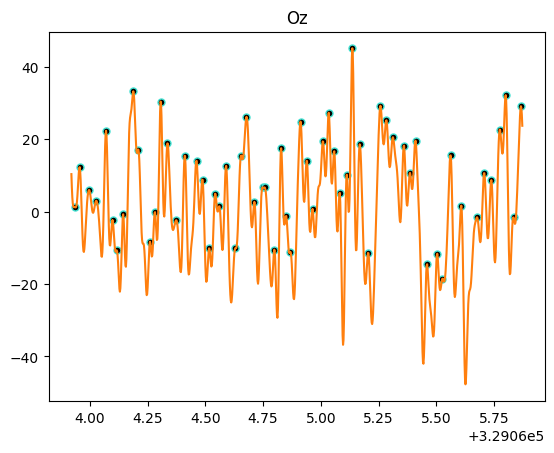

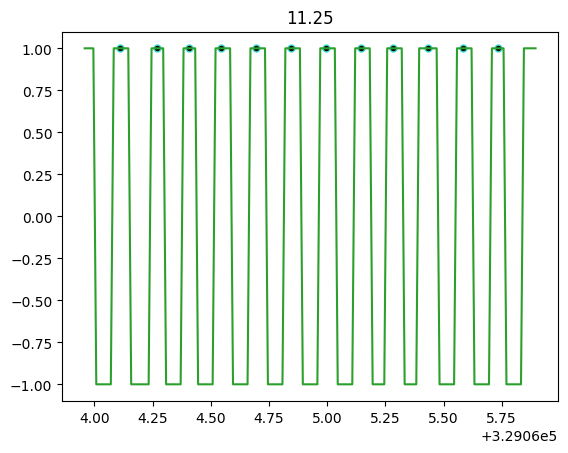

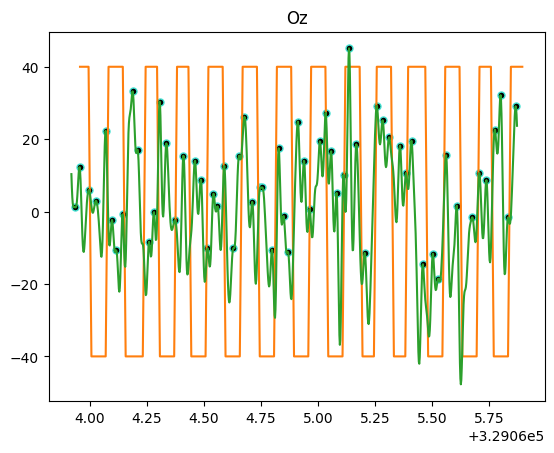

In [431]:
stream, df_stream, df_stream_ts = init_data(data)
stream_iir, df_stream_iir, df_stream_ts_iir = init_data(data_iir)
stream_frequencies, df_stream_frequencies, df_stream_ts_frequencies = init_freq_data(data_frequencies)
s = 8
e = 14
start, end = get_range(df_stream, s, e)
#plot_eeg_single(df_stream, df_stream_ts, 'Oz', start=start, end=end)
start, end = get_range(df_stream_iir, s, e)
plot_eeg_single(df_stream_iir, df_stream_ts_iir, 'Oz', start=start, end=end)
start_freq, end_freq = get_range(df_stream_frequencies, s, e)
plot_freq_single(df_stream_frequencies, df_stream_ts_frequencies, '11.25', start=start_freq, end=end_freq)
start, end = get_range(df_stream_iir, s, e)
plot_eeg_freq(df_stream_iir, df_stream_ts_iir, 'Oz', df_stream_frequencies, df_stream_ts_frequencies,'11.25', start=[start,start_freq], end=[end, end_freq])